DataFrame contains NaN values: False


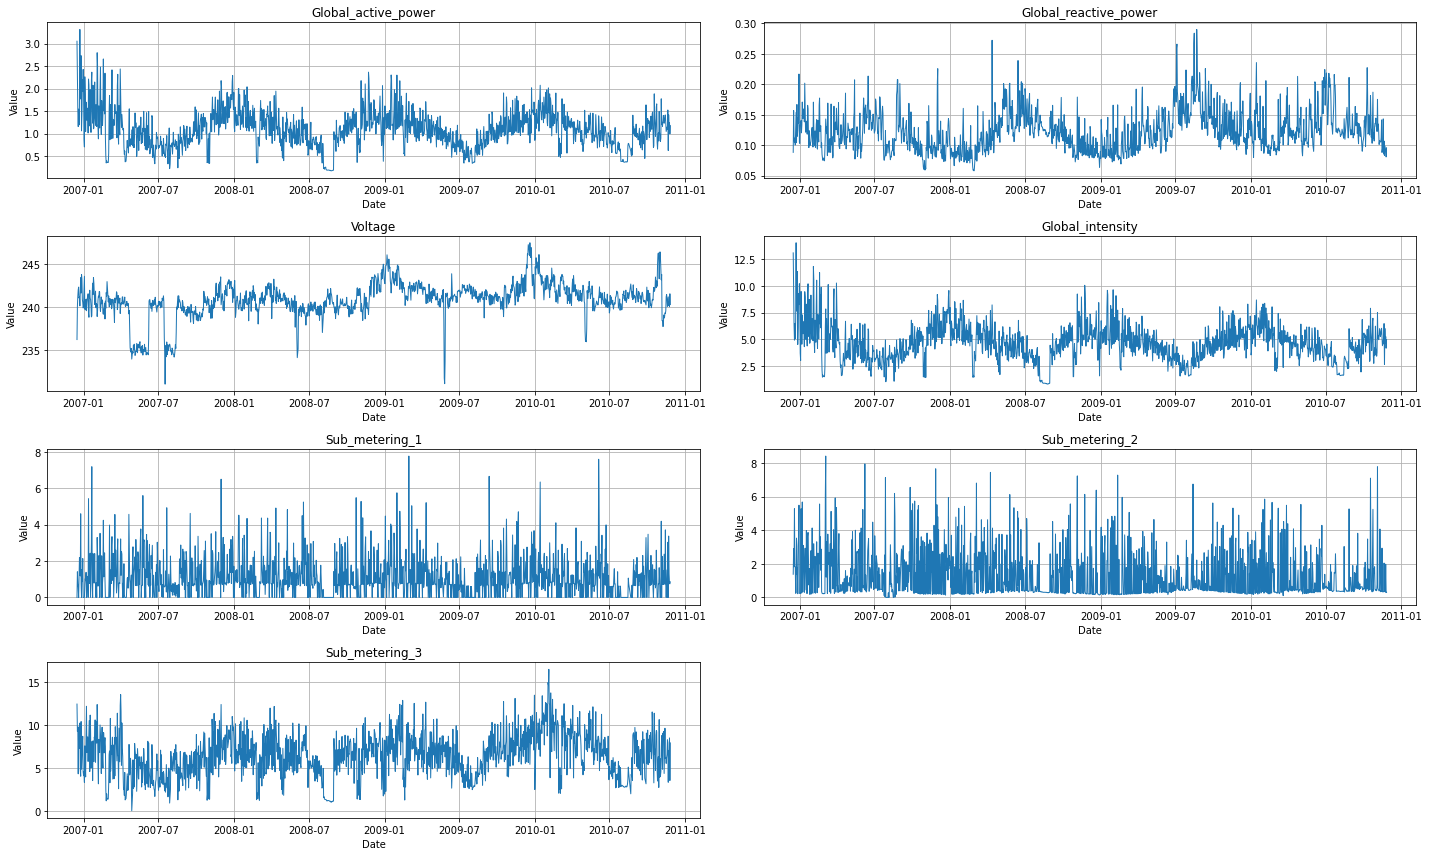

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
torch.manual_seed(123)

dataset_file = 'household_power_consumption.txt'
data = pd.read_csv(dataset_file, sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')
data=data.dropna()
# Resample the data to have one value per day
daily_data = data.resample('D').mean()
daily_data = daily_data.dropna()
has_nans = daily_data.isna().any().any()

print(f"DataFrame contains NaN values: {has_nans}")
# Plot each time series
plt.figure(figsize=(20, 12))
for i, col in enumerate(daily_data.columns):
    plt.subplot(4, 2, i+1)
    plt.plot(daily_data.index, daily_data[col],linewidth=1)
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
time_series = daily_data.values
ts_train = time_series[:1000]
ts_test = time_series[1000:]
#time_series = torch.from_numpy(time_series).float()
print(time_series.shape)


(1433, 7)


In [3]:
x_train = torch.from_numpy(ts_train[:-3]).float()
y_train = torch.from_numpy(ts_train[12:]).float()
x_test = torch.from_numpy(ts_test[:-3]).float()
y_test = torch.from_numpy(ts_test[12:]).float()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        # Forward pass through the fully connected layer
        out = self.fc(out[:, -1, :])

        return out


# Create an instance of the LSTM model
input_size = 7
hidden_size = 64
output_size = 7
lstm_model = LSTMModel(input_size, hidden_size, output_size)

# Reshape the input data to have 3 lags for each dimension
x_train = x_train.unfold(0, 10, 1).unsqueeze(2).reshape(-1, 10, input_size)
x_test = x_test.unfold(0, 10, 1).unsqueeze(2).reshape(-1, 10, input_size)

# Reshape the target data to match the size of the predicted tensor
y_train = y_train.reshape(-1, output_size)
y_test = y_test.reshape(-1, output_size)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

print()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = lstm_model(x_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([997, 7])
torch.Size([988, 7])
torch.Size([430, 7])
torch.Size([421, 7])

torch.Size([988, 10, 7])
torch.Size([988, 7])
torch.Size([421, 10, 7])
torch.Size([421, 7])
Epoch [100/10000], Loss: 4478.4409
Epoch [200/10000], Loss: 2188.4116
Epoch [300/10000], Loss: 952.1301
Epoch [400/10000], Loss: 367.3557
Epoch [500/10000], Loss: 124.5766
Epoch [600/10000], Loss: 37.7509
Epoch [700/10000], Loss: 11.2292
Epoch [800/10000], Loss: 4.3383
Epoch [900/10000], Loss: 2.8194
Epoch [1000/10000], Loss: 2.3561
Epoch [1100/10000], Loss: 2.1431
Epoch [1200/10000], Loss: 2.1083
Epoch [1300/10000], Loss: 2.0766
Epoch [1400/10000], Loss: 2.0479
Epoch [1500/10000], Loss: 2.0324
Epoch [1600/10000], Loss: 2.0234
Epoch [1700/10000], Loss: 2.0210
Epoch [1800/10000], Loss: 2.0100
Epoch [1900/10000], Loss: 2.0050
Epoch [2000/10000], Loss: 2.0012
Epoch [2100/10000], Loss: 2.0002
Epoch [2200/10000], Loss: 1.9986
Epoch [2300/10000], Loss: 1.9935
Epoch [2400/10000], Loss: 1.9913
Epoch [2500/10000], Loss: 

In [4]:
outputs.shape


torch.Size([988, 7])

In [5]:
predicted = lstm_model(x_test).detach().numpy()

In [6]:
print(predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(predicted) - y_test),dim=0)
print('Metrics for Original Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

(421, 7)
Metrics for Original Prediction
Dimension 1:
MSE: 0.1694
MAE: 0.3163

Dimension 2:
MSE: 0.0013
MAE: 0.0264

Dimension 3:
MSE: 4.5247
MAE: 1.4870

Dimension 4:
MSE: 2.9283
MAE: 1.3237

Dimension 5:
MSE: 1.2496
MAE: 0.8284

Dimension 6:
MSE: 2.0448
MAE: 1.0505

Dimension 7:
MSE: 9.1500
MAE: 2.2932



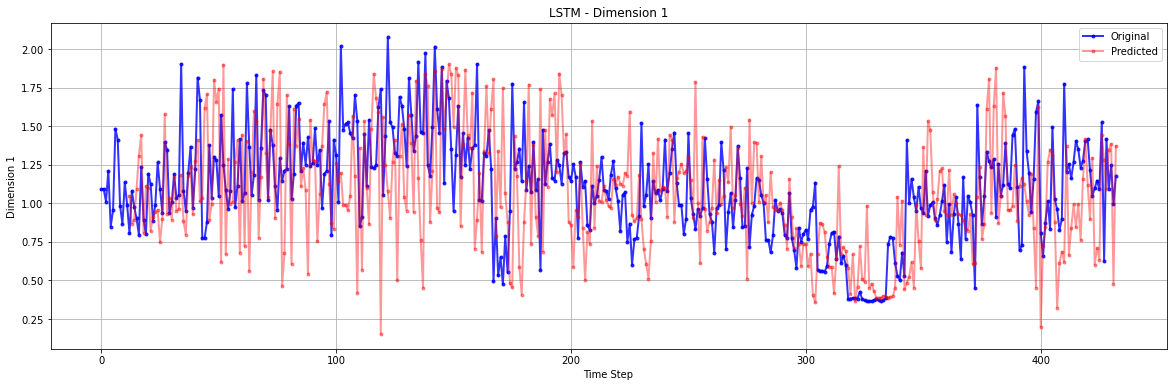

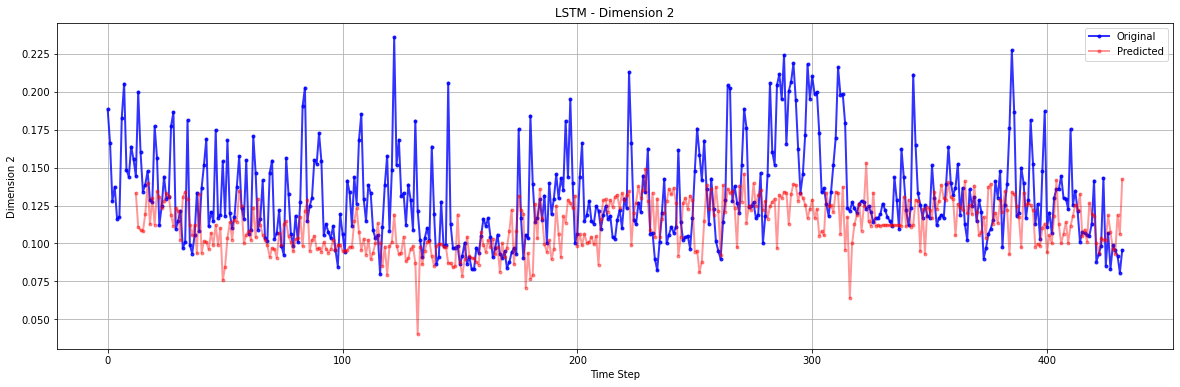

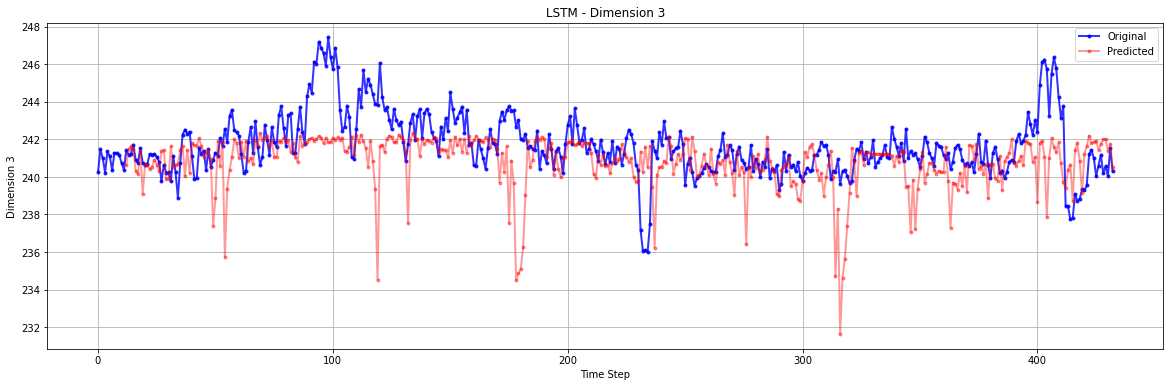

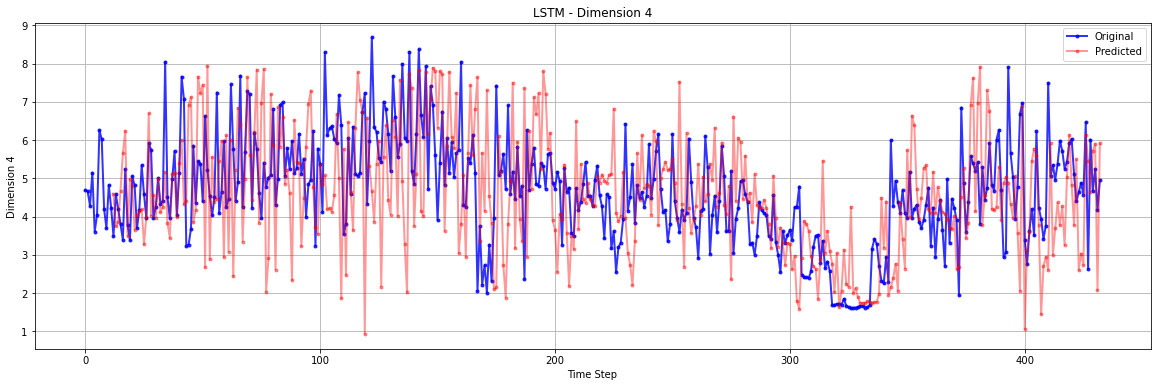

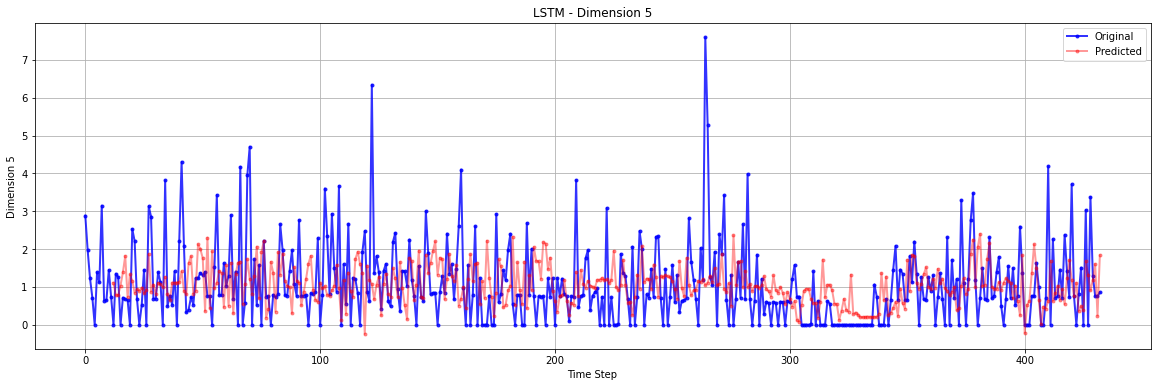

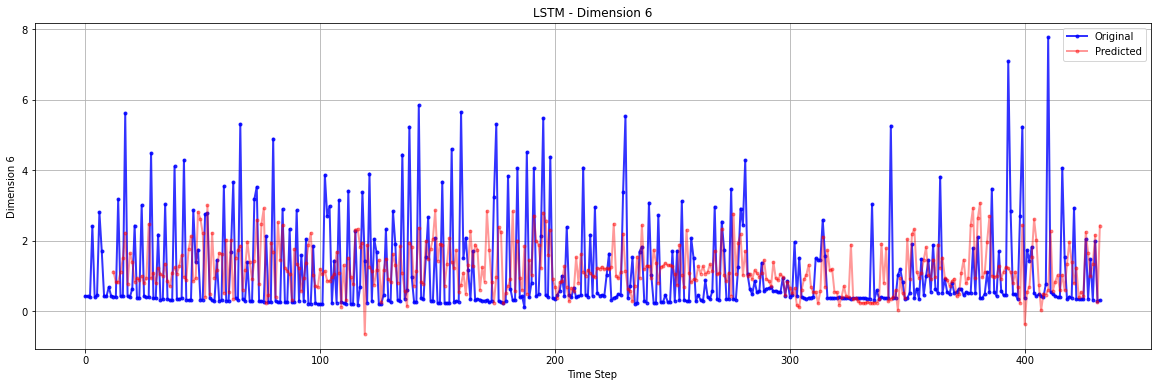

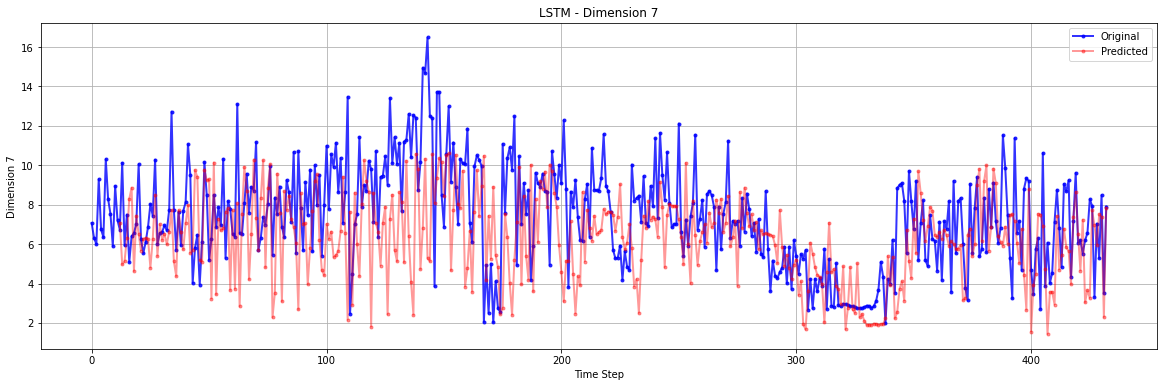

In [7]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,marker='.',alpha=0.8)
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=0.4,marker='.')
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data

In [9]:
x_test.requires_grad = True
outputs = lstm_model(x_test)        
loss = criterion(outputs, y_test)
loss.backward(retain_graph=True)
data_grad = x_test.grad.data

In [10]:
perturbed_data = fgsm_attack(x_test, 0.2, data_grad)
perturbed_predicted = lstm_model(perturbed_data).detach().numpy()
print(perturbed_predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y_test),dim=0)
print('Metrics for on_FGSM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

(421, 7)
Metrics for on_FGSM Prediction
Dimension 1:
MSE: 0.3679
MAE: 0.5094

Dimension 2:
MSE: 0.0015
MAE: 0.0281

Dimension 3:
MSE: 8.5766
MAE: 2.0633

Dimension 4:
MSE: 6.4564
MAE: 2.1366

Dimension 5:
MSE: 1.9127
MAE: 1.0622

Dimension 6:
MSE: 3.1247
MAE: 1.3109

Dimension 7:
MSE: 16.8342
MAE: 3.3493



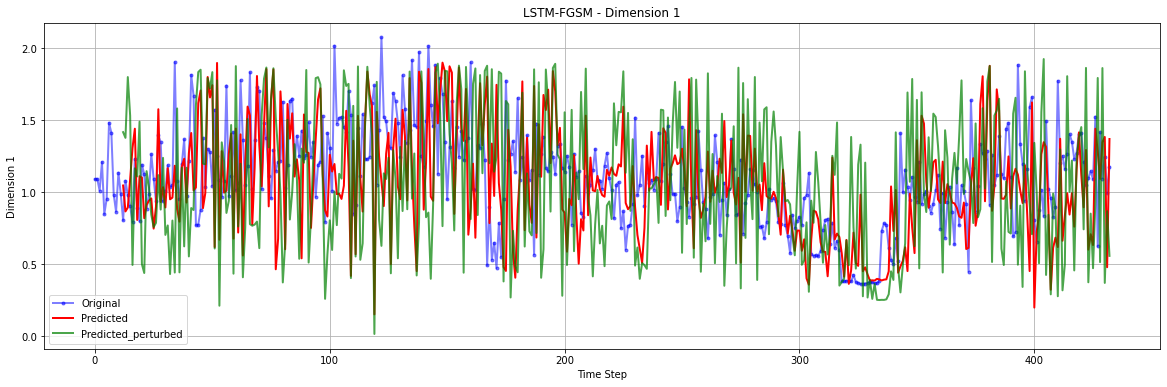

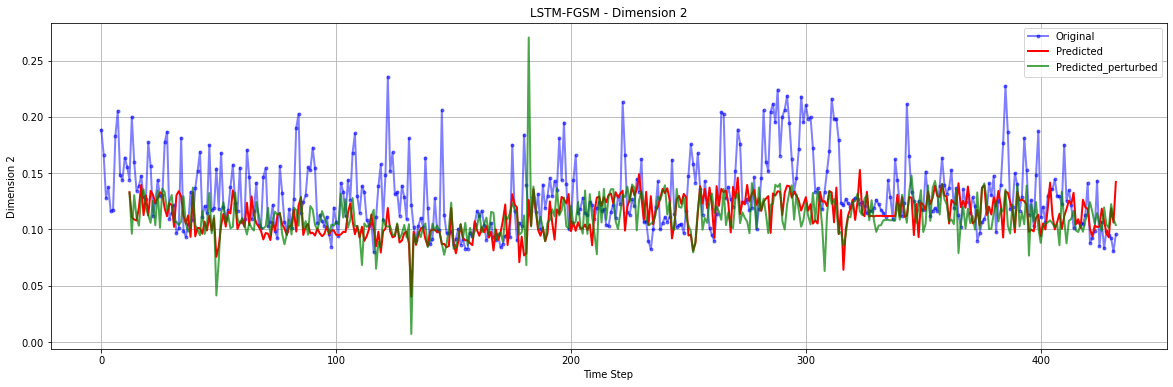

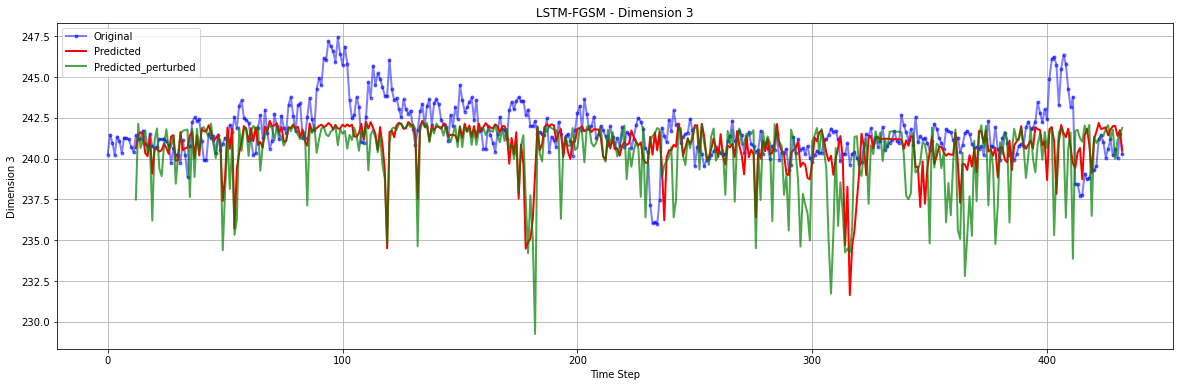

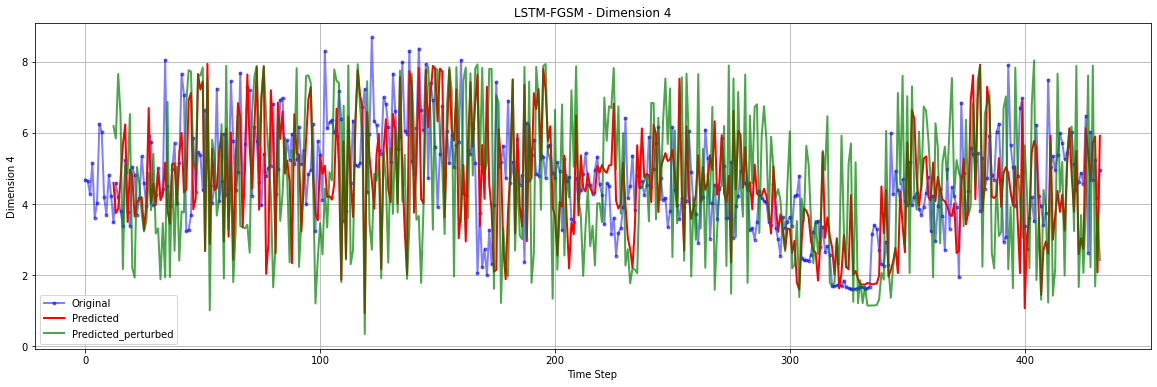

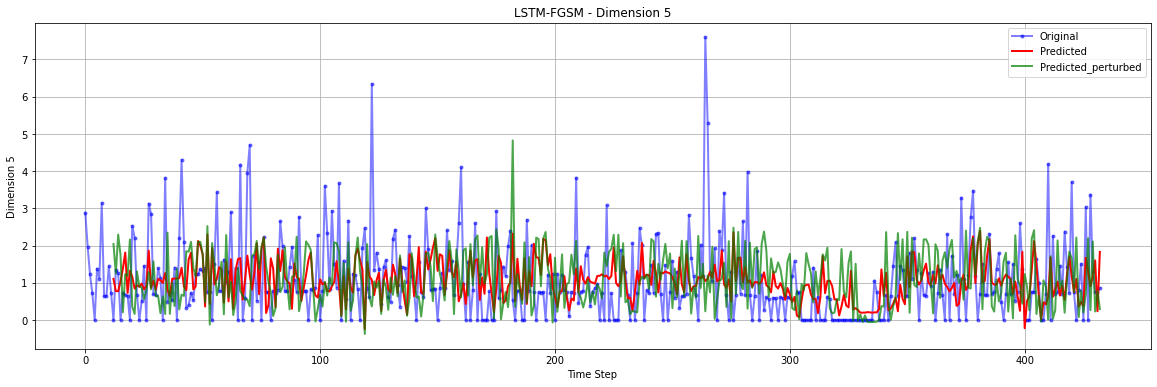

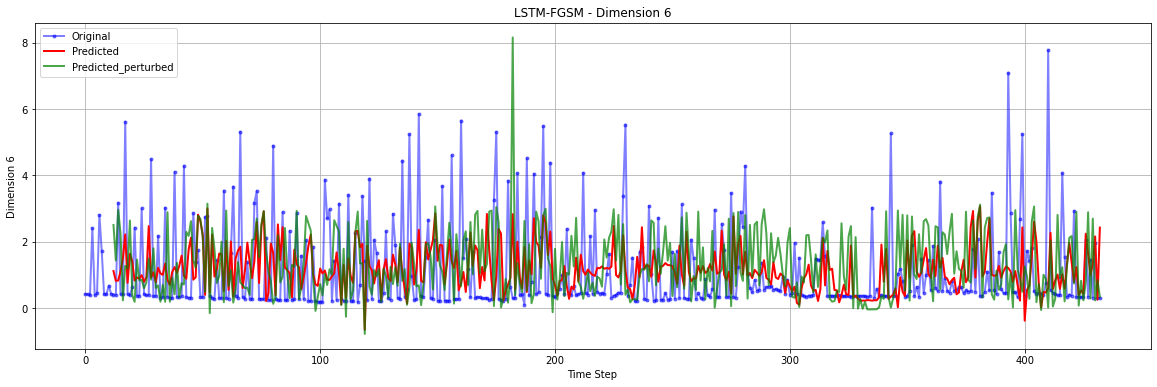

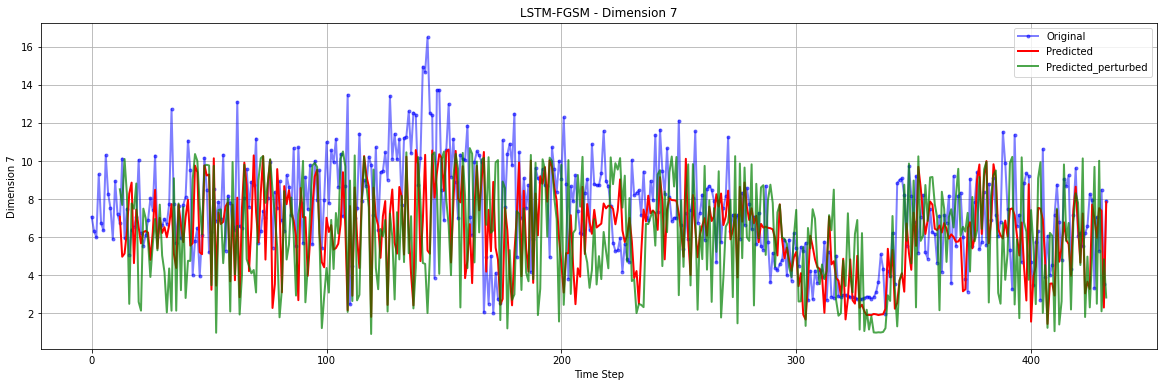

In [11]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM-FGSM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs, Y)
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

In [13]:
perturbed_data = bim(x_test, y_test, lstm_model, epsilon=0.2, alpha=0.002, I=200)
print(perturbed_data.shape)
# Generate predictions from the perturbed data
perturbed_x = perturbed_data.float()
perturbed_predicted = lstm_model(perturbed_x).detach().numpy()
print(perturbed_predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y_test),dim=0)
print('Metrics for on_BIM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

torch.Size([421, 10, 7])
(421, 7)
Metrics for on_BIM Prediction
Dimension 1:
MSE: 0.6539
MAE: 0.7432

Dimension 2:
MSE: 0.0023
MAE: 0.0353

Dimension 3:
MSE: 21.2729
MAE: 3.3172

Dimension 4:
MSE: 11.5009
MAE: 3.1441

Dimension 5:
MSE: 2.5942
MAE: 1.2944

Dimension 6:
MSE: 4.0269
MAE: 1.5447

Dimension 7:
MSE: 30.4164
MAE: 4.8573



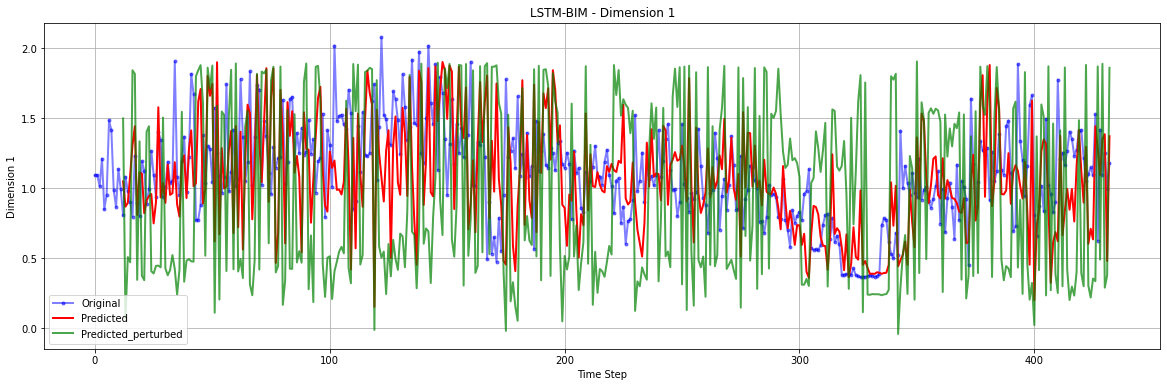

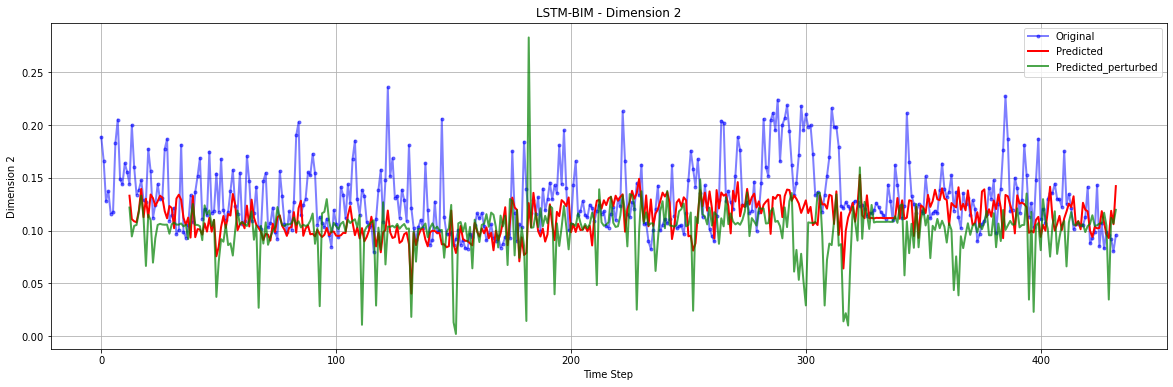

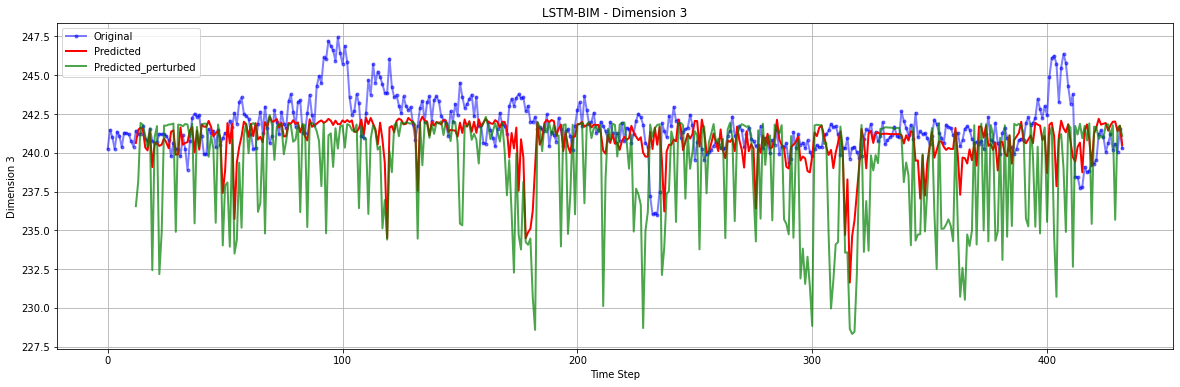

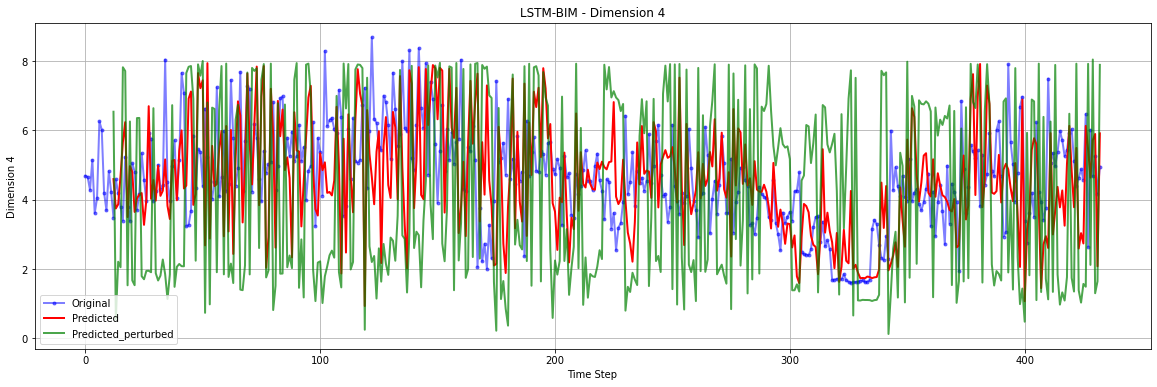

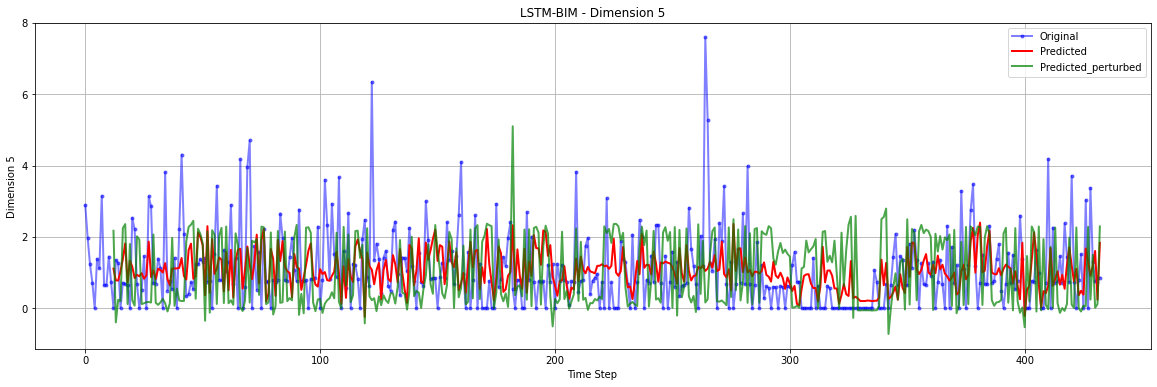

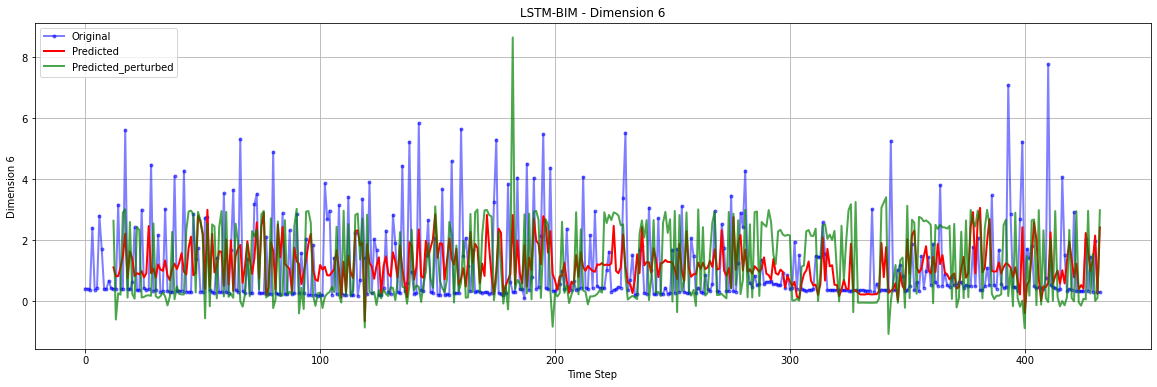

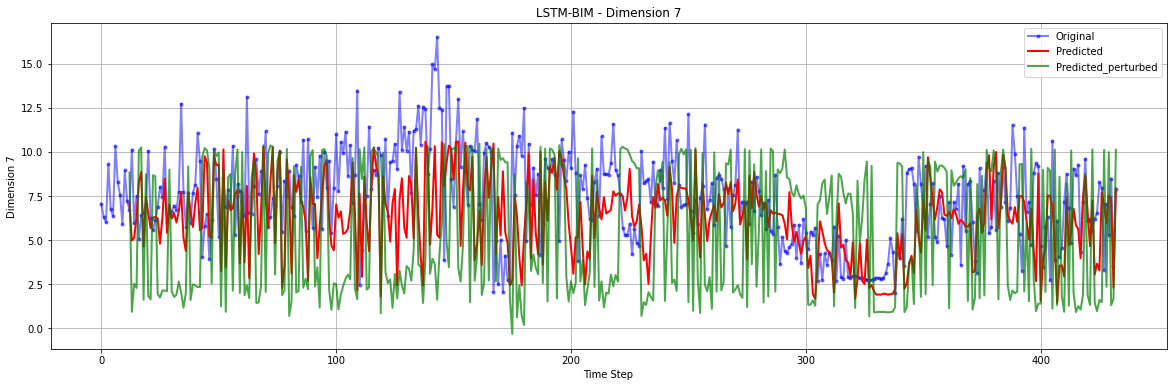

In [14]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM-BIM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()